In [1]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Activation, Add, AveragePooling2D, Concatenate
from tensorflow.keras.models import Sequential
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import concatenate
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import os
import joblib
import seaborn as sns
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, cross_validate

In [2]:
import os
FOLDER_DATA = '/Users/khunnoot/Desktop/predict_irradiance/trainning/Data'
Images = 'Image_train.csv'
Attribute = 'Attribute_train.csv'

In [3]:
Image_df = pd.read_csv(os.path.join(FOLDER_DATA, Images),parse_dates=['Datetime'])
ATT = pd.read_csv(os.path.join(FOLDER_DATA, Attribute),parse_dates=['Datetime'])

In [4]:
'''''''''

Function: train_test_split(df, test_size=0.2, random_state=42, split_by_k=True)

Inputs:

df: The input dataframe containing the data to be split.
test_size: The proportion of the data to be allocated for testing. It is typically expressed as a decimal value between 0 and 1.
random_state: An optional parameter that sets the random seed for reproducibility. It ensures the same data split is obtained when the function is executed multiple times with the same random seed.
split_by_k: A boolean flag indicating whether the data should be split based on the clear-sky index criteria.

Outputs:

Training dataframe: The dataframe containing the data for training.
Testing dataframe: The dataframe containing the data for testing.

The function performs the data split by shuffling the data from three sets based on the clear-sky index criteria:

Set i) contains data points where the clear-sky index (k) is greater than 0.6.
Set ii) contains data points where the clear-sky index is between 0.3 and 0.6 (inclusive).
Set iii) contains data points where the clear-sky index is less than or equal to 0.3.

The function then splits the shuffled data into training and testing sets according to the specified test size.

'''''''''

def train_test_splits(df, test_size=0.3, random_state=42, split_by_k = True):
        df = df.copy()
        df['date'] = df.index.date
        INDEX = df[['site_name','k']].copy()
        INDEX = INDEX.groupby(by=[INDEX.index.date,'site_name']).mean()
        INDEX.reset_index(level=1, inplace=True)
        
        if split_by_k :
            klow = INDEX[INDEX.k<=0.3]
            kmed = INDEX[(INDEX.k>0.3) & (INDEX.k<=0.6)]
            khigh =  INDEX[(INDEX.k>0.6)]
            klow_test = klow.sample(frac=test_size,random_state=random_state)
            kmed_test = kmed.sample(frac=test_size,random_state=random_state)
            khigh_test = khigh.sample(frac=test_size,random_state=random_state)
            X_test = pd.concat([klow_test, kmed_test, khigh_test])

        else:
            X_test = INDEX.sample(frac=test_size, random_state = random_state)
            
        X_test.reset_index(inplace=True)
        X_test = X_test.rename(columns={'index':'date'})
        X_test = X_test.drop(columns = ['k'])
        X_test = df.reset_index().merge(X_test,on=['date','site_name']).set_index('Datetime')
        X_train = pd.concat([df,X_test]).drop_duplicates(keep=False)
        X_train.drop(columns=['date'],inplace = True); X_test.drop(columns=['date'],inplace = True)
        
        return X_train, X_test

# Regression model

In [5]:
df = ATT.copy()
df.set_index('Datetime',inplace = True)
df.head(5)

,site_name,CI0_cm,CI1_cm,Iclr,I,k,HR,CI0_ov,CI1_ov
Datetime,,,,,,,,,
2023-02-07 08:00:00+07:00,ISL001,0.415686,0.537255,172.570155,110.3633,0.639527,8,0.090196,0.101961
2023-02-07 08:30:00+07:00,ISL001,0.317647,0.415686,288.475645,208.3990,0.722415,8,0.117647,0.090196
2023-02-07 09:00:00+07:00,ISL001,0.333333,0.317647,401.491557,437.6490,1.090058,9,0.070588,0.117647
2023-02-07 09:30:00+07:00,ISL001,0.388235,0.333333,506.299490,496.7265,0.981092,9,0.094118,0.070588
2023-02-07 10:00:00+07:00,ISL001,0.345098,0.388235,599.632417,482.6430,0.804898,10,0.062745,0.094118


    feature 1 : Iclr
    feature 2 : CI0_cm
    feature 3 : CI0_ov
    feature 4 : Iclr, CI0_cm
    feature 5 : Iclr, CI0_ov
    feature 6 : CI0_cm, CI0_ov
    feature 7 : CI0_cm, CI0_ov, Iclr

## Model training (Linear regression)

In [6]:
X = df[['site_name','Iclr','CI0_cm','CI0_ov','k']]
y = df[['site_name','I','k']]

X_train, X_test = train_test_splits(X, test_size = 0.5, random_state=42, split_by_k = True)
y_train, y_test = train_test_splits(y, test_size = 0.5, random_state=42, split_by_k = True)
X_train = X_train.drop(columns=['site_name','k'])
y_train = y_train.drop(columns=['site_name','k'])

X_test = X_test.drop(columns=['k'])
y_test = y_test.drop(columns=['k'])

In [7]:
predictors ={'ft1':X_train[['Iclr']],
             'ft2':X_train[['CI0_cm']],
             'ft3':X_train[['CI0_ov']],
             'ft4':X_train[['Iclr','CI0_cm']],
             'ft5':X_train[['Iclr','CI0_ov']],
             'ft6':X_train[['CI0_cm','CI0_ov']],
             'ft7':X_train[['Iclr','CI0_cm','CI0_ov']]}

## Model selection criterion

In [8]:
train_score=[]
test_score=[]
aic = []
bic = []
for predictor in predictors:
    print(predictor,end='\r')
    feature =  predictors[predictor]
    model = LinearRegression()
    cve = cross_validate(model, feature,y_train, cv=5, scoring='neg_mean_absolute_error',return_train_score=True)
    regr = OLS(y_train, add_constant(feature)).fit()
    train_score.append(-cve['train_score'].mean())
    test_score.append(-cve['test_score'].mean())
    aic.append(regr.aic/regr.nobs)
    bic.append(regr.bic/regr.nobs)

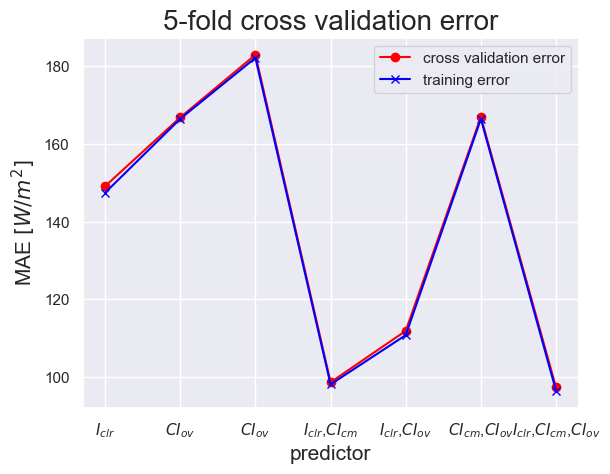

In [9]:
sns.set()
ind = [d for d in range(7)]
plt.plot(ind ,test_score,'-o',color='red',label = "cross validation error")
plt.plot(ind ,train_score,'-x',color='blue',label = "training error")
plt.legend()
plt.xlabel('predictor',fontsize=15)
plt.ylabel('MAE $[W/m^2]$',fontsize=15)
plt.title('5-fold cross validation error',fontsize=20)
plt.xticks(ind,['$I_{clr}$','$CI_{ov}$','$CI_{ov}$','$I_{clr}$,$CI_{cm}$','$I_{clr}$,$CI_{ov}$',
                '$CI_{cm}$,$CI_{ov}$','$I_{clr}$,$CI_{cm}$,$CI_{ov}$']);

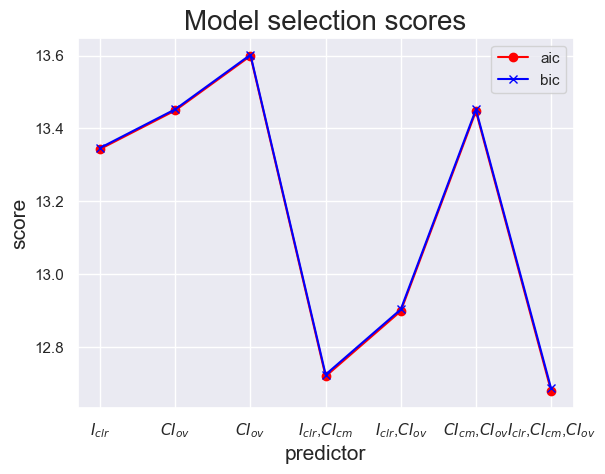

In [10]:
sns.set()
plt.plot(ind ,aic,'-o',color='red',label = "aic")
plt.plot(ind ,bic,'-x',color='blue',label = "bic")
plt.legend()
plt.xlabel('predictor',fontsize=15)
plt.ylabel('score',fontsize=15)
plt.title('Model selection scores',fontsize=20)
plt.xticks(ind,['$I_{clr}$','$CI_{ov}$','$CI_{ov}$','$I_{clr}$,$CI_{cm}$','$I_{clr}$,$CI_{ov}$',
                '$CI_{cm}$,$CI_{ov}$','$I_{clr}$,$CI_{cm}$,$CI_{ov}$']);

In [11]:
model = LinearRegression()
model.fit(X_train,y_train)
y_test['OLS'] = model.predict(X_test.drop(columns=['site_name']))
np.sqrt(mean_squared_error(y_test[['I']], y_test[['OLS']]))

137.98626341664271

In [12]:
print(model.coef_)
print(model.intercept_)

[[   0.77289927 -576.66607121 -173.83361704]]
[294.26453364]


In [13]:
compare = y_test.copy()
compare.head()

,site_name,I,OLS
Datetime,,,
2023-02-07 08:00:00+07:00,ISL001,110.3633,172.252600
2023-02-07 08:30:00+07:00,ISL001,208.3990,313.599855
2023-02-07 09:00:00+07:00,ISL001,437.6490,400.084434
2023-02-07 09:30:00+07:00,ISL001,496.7265,445.340109
2023-02-07 10:00:00+07:00,ISL001,482.6430,547.806455


## Model training (Polynomial Regression)

In [14]:
X = df[['site_name','Iclr','CI0_cm','CI0_ov','k']]
y = df[['site_name','k']]

X_train, X_test = train_test_splits(X, test_size=0.5, random_state=42, split_by_k = True)
y_train, y_test = train_test_splits(y, test_size=0.5, random_state=42, split_by_k = True)
X_train = X_train.drop(columns=['site_name','k'])
y_train = y_train.drop(columns=['site_name'])

In [15]:
train_score=[]
test_score=[]
degress = [int(d) for d in range(1,16)]
for e in degress:
    poly = PolynomialFeatures(degree=e, include_bias=False)
    poly_features = poly.fit_transform(X_train[['CI0_cm']])
    poly_features = poly_features
    poly_reg_model = LinearRegression()
    cve=cross_validate(poly_reg_model, poly_features, y_train, cv=5, scoring='neg_mean_absolute_error',return_train_score=True)
    train_score.append(-cve['train_score'].mean())
    test_score.append(-cve['test_score'].mean())

Text(0.5, 1.0, '5-fold cross validation error')

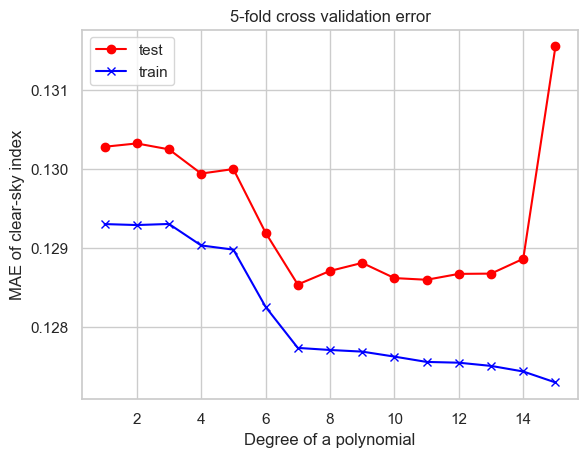

In [16]:
sns.set(style = 'whitegrid')
plt.plot(degress ,test_score,'-o',label = "test",color='red')
plt.plot(degress ,train_score,'-x',label = "train",color='blue')
plt.legend()
plt.xlabel('Degree of a polynomial')
plt.ylabel('MAE of clear-sky index')
plt.title('5-fold cross validation error')

In [17]:
poly = PolynomialFeatures(degree=7, include_bias=False)
poly_features = poly.fit_transform(X_train[['CI0_cm']])
poly_features = poly_features
poly_reg_model = LinearRegression()
poly_reg_model.fit(poly_features,y_train)
poly_test = poly.fit_transform(X_test[['CI0_cm']])
y_test['khat'] = poly_reg_model.predict(poly_test)
y_test['Iclr'] = X_test.Iclr
y_test['I'] = y_test.k*y_test.Iclr
y_test['Ihat']=y_test.khat*y_test.Iclr
mean_absolute_error(y_test[['I']], y_test[['Ihat']])

95.1597977077146

In [18]:
print(poly_reg_model.coef_)
print(poly_reg_model.intercept_)

[[  153.47940745  -936.21152674  3009.21031974 -5548.24698691
   5879.66490264 -3324.83285837   776.34008712]]
[-9.20078252]


In [19]:
compare['poly'] = y_test.Ihat
compare

,site_name,I,OLS,poly
Datetime,,,,
2023-02-07 08:00:00+07:00,ISL001,110.3633,172.252600,138.025779
2023-02-07 08:30:00+07:00,ISL001,208.3990,313.599855,260.070233
2023-02-07 09:00:00+07:00,ISL001,437.6490,400.084434,353.791449
2023-02-07 09:30:00+07:00,ISL001,496.7265,445.340109,416.610174
2023-02-07 10:00:00+07:00,ISL001,482.6430,547.806455,519.840215
...,...,...,...,...
2023-06-29 14:00:00+07:00,ISL042,341.7507,661.496136,676.362402
2023-06-29 14:30:00+07:00,ISL042,807.5103,799.864254,525.121323
2023-06-29 15:00:00+07:00,ISL042,620.6790,702.650892,714.141976


# Tree-base model

In [20]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV, cross_validate

In [21]:
X, y = df.drop(columns=['I']), df[['CI0_cm','CI1_ov','site_name','I','k']] 

X_train, X_test = train_test_splits(X, test_size=0.5, random_state=42, split_by_k = True)
y_train, y_test = train_test_splits(y, test_size=0.5, random_state=42, split_by_k = True)

compar = y_test.copy()
y_train, y_test = y_train.I, y_test.I

X_train = X_train[['CI0_cm','CI1_cm','CI0_ov','CI1_ov','Iclr','HR']]
X_test = X_test[['CI0_cm','CI1_cm','CI0_ov','CI1_ov','Iclr','HR']]

In [22]:
model1 = XGBRegressor()
model2 = RandomForestRegressor()

## Grid search XGBoost

In [23]:
param_grid = {
    'n_estimators':[100],
    'max_depth':[6,8,10],
    'min_child_weight':[5,7,9,11],
    'colsample_bytree':[0.3,0.4,0.6,0.8],
    'subsample':[0.8,1]}

gcv1 = GridSearchCV(model1, param_grid, cv=5,scoring='neg_mean_absolute_error',verbose=2,n_jobs=-1)
best_model1 = gcv1.fit(X_train,y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


In [24]:
n_estimators = [100]
max_depth = [10,20,30,40]
max_features = [6,9,12]
min_samples_split = [4,8,16,32]
min_samples_leaf =  [4,8,16,32]
bootstrap = [True]


param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


gcv2 = GridSearchCV(estimator = model2, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2,scoring='neg_mean_absolute_error',return_train_score=True)

best_model2 = gcv2.fit(X_train, y_train)

Fitting 5 folds for each of 192 candidates, totalling 960 fits


In [25]:
data = pd.DataFrame(best_model1.cv_results_)
data.to_csv('gcv1.csv')
best_model1.best_params_

{'colsample_bytree': 0.8,
 'max_depth': 6,
 'min_child_weight': 9,
 'n_estimators': 100,
 'subsample': 1}

In [26]:
data = pd.DataFrame(best_model2.cv_results_)
data.to_csv('gcv2.csv')
best_model2.best_params_

{'bootstrap': True,
 'max_depth': 10,
 'max_features': 6,
 'min_samples_leaf': 4,
 'min_samples_split': 4,
 'n_estimators': 100}

## Model retraining

In [27]:
XGB = XGBRegressor(n_estimators=100,max_depth=6,min_child_weight=9,colsample_bytree=0.8,subsample=1)
XGB.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=9, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [28]:
RF = RandomForestRegressor(n_estimators=100,max_depth=40,max_features=6,min_samples_leaf=4,min_samples_split=4,bootstrap=True)
RF.fit(X_train,y_train)

RandomForestRegressor(max_depth=40, max_features=6, min_samples_leaf=4,
                      min_samples_split=4)

In [29]:
compare['yXGB']=XGB.predict(X_test)
compare['yRF']=RF.predict(X_test)
compare

,site_name,I,OLS,poly,yXGB,yRF
Datetime,,,,,,
2023-02-07 08:00:00+07:00,ISL001,110.3633,172.252600,138.025779,210.439102,176.293929
2023-02-07 08:30:00+07:00,ISL001,208.3990,313.599855,260.070233,255.959946,281.717812
2023-02-07 09:00:00+07:00,ISL001,437.6490,400.084434,353.791449,374.977234,381.972205
2023-02-07 09:30:00+07:00,ISL001,496.7265,445.340109,416.610174,447.586487,432.071115
2023-02-07 10:00:00+07:00,ISL001,482.6430,547.806455,519.840215,549.731262,506.853844
...,...,...,...,...,...,...
2023-06-29 14:00:00+07:00,ISL042,341.7507,661.496136,676.362402,624.427795,631.765323
2023-06-29 14:30:00+07:00,ISL042,807.5103,799.864254,525.121323,655.842041,716.637547
2023-06-29 15:00:00+07:00,ISL042,620.6790,702.650892,714.141976,727.147827,732.558014


In [50]:
import pickle
pickle.dump(RF, open('RF.pkl','wb'))

In [31]:
print('MAE of XGBoosting is {}'.format(mean_absolute_error(compare[['I']],compare[['yXGB']])))
print('MAE of RF is {}'.format(mean_absolute_error(compare[['I']],compare[['yRF']])))

MAE of XGBoosting is 93.74026105215854
MAE of RF is 89.35060761574664


# CNN model

In [32]:
# define CNN model
input_shape = (16, 16, 2)
img_inputs = keras.Input(shape=input_shape)
ATT_input = keras.Input(shape=(6))
conv1 = layers.Conv2D(16, kernel_size=(5, 5), activation='relu',padding='same')(img_inputs)
conv2 = layers.Conv2D(16, kernel_size=(5, 5), activation='relu',padding='same')(conv1)
pool1 = layers.MaxPooling2D((2, 2),strides=(2,2))(conv2)
conv3 = layers.Conv2D(16, kernel_size=(5, 5), activation='relu',padding='same')(pool1)
conv4 = layers.Conv2D(16, kernel_size=(5, 5), activation='relu',padding='same')(conv3)
pool2 = layers.MaxPooling2D((2, 2),strides=(2,2))(conv4)
conv5 = layers.Conv2D(16, kernel_size=(5, 5), activation='relu',padding='same')(pool2)
conv6 = layers.Conv2D(16, kernel_size=(5, 5), activation='relu',padding='same')(conv5)
pool3 = layers.MaxPooling2D((2, 2),strides=(2,2))(conv6)
flatten_cnn = layers.Flatten()(pool3)
dense1 = layers.Dense(6)(ATT_input) # define MLP model
flatten_mlp = layers.Flatten()(dense1)
merged = layers.concatenate([flatten_cnn, flatten_mlp]) # combine CNN and MLP
dense3 = layers.Dense(64, activation='relu')(merged)
dense4 = layers.Dense(16, activation='relu')(dense3)
outputs = layers.Dense(1)(dense4)
CNN = keras.Model(inputs=[img_inputs, ATT_input], outputs=outputs, name="CNN")
CNN.summary()

Model: "CNN"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 16, 16, 2)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 16, 16, 16)           816       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 16, 16, 16)           6416      ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 8, 8, 16)             0         ['conv2d_1[0][0]']            
 D)                                                                                             

In [33]:
Image = Image_df.copy()
Image.set_index('Datetime', inplace = True)
Att = ATT.copy()
Att.set_index('Datetime', inplace = True)

In [34]:
#train test split
train_data, test_data = train_test_splits(Image, test_size=0.5, random_state=42, split_by_k = True)
train_ATT, test_ATT = train_test_splits(Att, test_size=0.5, random_state=42, split_by_k = True)

In [35]:
#Train CNN model
TargetVariable=['I']
Predictors=list(Image.columns.drop(['site_name','k','Iclr','I']))

X_train = train_data[Predictors].values.reshape(-1,16,16,2)
y_train = train_data[TargetVariable].values
X_test = test_data[Predictors].values.reshape(-1,16,16,2)
y_test = test_data[TargetVariable].values

X_train=X_train/255
X_test=X_test/255

ATT_taget = ['I']
ATT_predictors = list(ATT.columns.drop(['I','site_name','k','Datetime']))
X_train_ATT = train_ATT[ATT_predictors].values
y_train_ATT = train_ATT[ATT_taget].values
X_test_ATT = test_ATT[ATT_predictors].values
y_test_ATT = test_ATT[ATT_taget].values

from sklearn.model_selection import train_test_split
#split train and validate set 
X_train_train, X_valid, y_train_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, shuffle = False) 
X_train_train_ATT, X_val_ATT, y_train_train_ATT, y_val_ATT = train_test_split(X_train_ATT, y_train_ATT, test_size=0.25, shuffle = False)

In [36]:
# Compile and train the Cloud2K model

from keras.optimizers import RMSprop,Adam
from keras import callbacks
from keras.callbacks import ReduceLROnPlateau

batch_size = 32
epochs = 500


earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                    mode ="min", patience = 20, 
                                    restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=3, min_lr=0.001)
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate = 0.002)
    
CNN.compile(optimizer = optimizer, loss = 'mean_absolute_error')
CNN_ = CNN.fit([X_train_train,X_train_train_ATT], y_train_train, epochs = epochs, 
                    batch_size = batch_size, validation_data = ([X_valid, X_val_ATT], y_valid) ,
                    verbose = 1,callbacks = [earlystopping, reduce_lr] ) 

Epoch 1/500
91/91 [==============================] - 2s 18ms/step - loss: 221.4973 - val_loss: 135.8427 - lr: 0.0020
Epoch 2/500
91/91 [==============================] - 2s 18ms/step - loss: 138.9446 - val_loss: 128.7930 - lr: 0.0020
Epoch 3/500
91/91 [==============================] - 2s 23ms/step - loss: 127.8783 - val_loss: 121.1439 - lr: 0.0020
Epoch 4/500
91/91 [==============================] - 2s 19ms/step - loss: 116.2833 - val_loss: 106.3064 - lr: 0.0020
Epoch 5/500
91/91 [==============================] - 1s 15ms/step - loss: 112.0546 - val_loss: 103.9517 - lr: 0.0020
Epoch 6/500
91/91 [==============================] - 2s 19ms/step - loss: 110.0809 - val_loss: 102.4797 - lr: 0.0020
Epoch 7/500
91/91 [==============================] - 2s 20ms/step - loss: 110.6402 - val_loss: 102.7070 - lr: 0.0020
Epoch 8/500
91/91 [==============================] - 2s 20ms/step - loss: 109.9895 - val_loss: 114.5256 - lr: 0.0020
Epoch 9/500
91/91 [==============================] - 2s 18ms/ste

Epoch 71/500
91/91 [==============================] - 1s 15ms/step - loss: 99.4933 - val_loss: 100.0882 - lr: 0.0010
Epoch 72/500
91/91 [==============================] - 1s 15ms/step - loss: 100.8641 - val_loss: 96.5910 - lr: 0.0010
Epoch 73/500
91/91 [==============================] - 1s 14ms/step - loss: 99.7747 - val_loss: 104.3596 - lr: 0.0010
Epoch 74/500
91/91 [==============================] - 1s 16ms/step - loss: 101.3762 - val_loss: 101.5494 - lr: 0.0010
Epoch 75/500
91/91 [==============================] - 1s 16ms/step - loss: 100.7982 - val_loss: 96.7448 - lr: 0.0010
Epoch 76/500
91/91 [==============================] - 1s 16ms/step - loss: 99.0657 - val_loss: 96.8504 - lr: 0.0010
Epoch 77/500
91/91 [==============================] - 2s 18ms/step - loss: 98.9268 - val_loss: 95.0223 - lr: 0.0010
Epoch 78/500
91/91 [==============================] - 2s 19ms/step - loss: 99.2345 - val_loss: 97.5468 - lr: 0.0010
Epoch 79/500
91/91 [==============================] - 2s 17ms/step

In [37]:
I_pred = CNN.predict([X_test,X_test_ATT])

117/117 [==============================] - 1s 6ms/step


In [38]:
compare['CNN'] = I_pred
compare

,site_name,I,OLS,poly,yXGB,yRF,CNN
Datetime,,,,,,,
2023-02-07 08:00:00+07:00,ISL001,110.3633,172.252600,138.025779,210.439102,176.293929,141.618530
2023-02-07 08:30:00+07:00,ISL001,208.3990,313.599855,260.070233,255.959946,281.717812,260.487427
2023-02-07 09:00:00+07:00,ISL001,437.6490,400.084434,353.791449,374.977234,381.972205,376.279633
2023-02-07 09:30:00+07:00,ISL001,496.7265,445.340109,416.610174,447.586487,432.071115,479.649170
2023-02-07 10:00:00+07:00,ISL001,482.6430,547.806455,519.840215,549.731262,506.853844,575.128601
...,...,...,...,...,...,...,...
2023-06-29 14:00:00+07:00,ISL042,341.7507,661.496136,676.362402,624.427795,631.765323,714.983826
2023-06-29 14:30:00+07:00,ISL042,807.5103,799.864254,525.121323,655.842041,716.637547,737.130920
2023-06-29 15:00:00+07:00,ISL042,620.6790,702.650892,714.141976,727.147827,732.558014,685.834717


In [39]:
mean_absolute_error(compare[['I']], compare[['CNN']])

96.47514342764407

In [42]:
# compare.to_csv('compare_model_result.csv')